# 5. Cluster analysis

This notebook shows some cluster analysis we can do with `scikit-learn`. We will apply `KMeans`, `DBSCAN`, and `AgglomerativeClustering` in the UMAP embedding from notebook 4, and try to give an interpretation of the respective cluster analysis. Keep in mind that `scikit-learn` and other packages offer many more clustering algorithms.

Make sure to have the required `embedding.npz` file in the correct path.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import matplotlib.colors as mcolors

## 5.1 Load the embedding

In [2]:
# load umap embedding
data = np.load('../example/embedding.npz')
embedding = data['embedding']
timestamps_hrs = data['timestamps_hrs']

## 5.2 Perform clustering and show results in embedding

In [3]:
N_CLUSTERS = 5 # number of clusters for KMeans and AgglomerativeClustering
EPSILON = 0.5 # maximum distance between points for DBSCAN
MIN_SAMPLES = 5 # minimum number of samples in a neighborhood for DBSCAN

In [4]:
# Clustering
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
kmeans_labels = kmeans.fit_predict(embedding)   

dbscan = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES)
dbscan_labels = dbscan.fit_predict(embedding)

agglo = AgglomerativeClustering(n_clusters=N_CLUSTERS)
agglo_labels = agglo.fit_predict(embedding)

In [6]:
# small function to plot clusters in embedding
def plot_clusters(ax, features, labels, title):
    # Create a list of unique labels
    unique_labels = np.unique(labels)
    n_colors = len(unique_labels)

    # Assign a color to each label
    colors = [cmap(i % cmap.N) for i in range(n_colors)]

    for label, color in zip(unique_labels, colors):
        mask = labels == label
        label_name = f"Cluster {label}" if label != -1 else "Noise"
        ax.scatter(features[mask, 0], features[mask, 1], s=10, c=[color], label=label_name)

    ax.set_title(title)
    ax.set_xlabel("UMAP Feature 1")
    ax.set_ylabel("UMAP Feature 2")
    ax.legend(markerscale=2, fontsize=8)

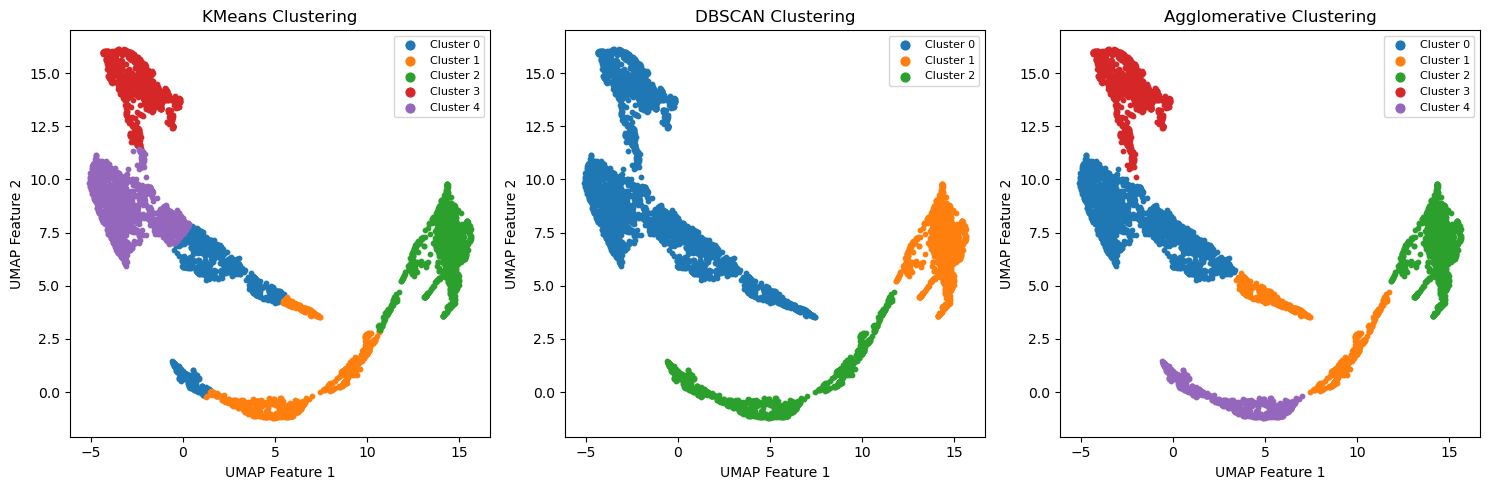

In [8]:
# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Define a discrete colormap
cmap = plt.get_cmap('tab10')  # up to 10 distinct colors

plot_clusters(axes[0], embedding, kmeans_labels, "KMeans Clustering")
plot_clusters(axes[1], embedding, dbscan_labels, "DBSCAN Clustering")
plot_clusters(axes[2], embedding, agglo_labels, "Agglomerative Clustering")

plt.tight_layout()
plt.show()


## 5.3 Interpretation of Clusters

The plot from above shows us the different clustering solutions from the different algorithms. That itself is already interesting, but it does not tell us much about the data. To gain insights about the data, we need to understand what these clusters might represent. There are many ways to do so. In our case, we will visualize the time evolution of the different clusters and try to get a "seismic fingerprint" of each cluster.

In [28]:
CLUSTER_TYPE = 'DBSCAN'  # Choose the clustering type: 'KMeans', 'DBSCAN', or 'Agglomerative'

Make sure you have the required `features.npz` in the right path.

In [29]:
# load psd for visualization purposes
data = np.load('../example/features.npz')
psd = data['psd_features']
psd_freqs = data['psd_freqs']

In [30]:
if CLUSTER_TYPE == 'KMeans':
    labels = kmeans_labels
elif CLUSTER_TYPE == 'DBSCAN':
    labels = dbscan_labels
elif CLUSTER_TYPE == 'Agglomerative':
    labels = agglo_labels

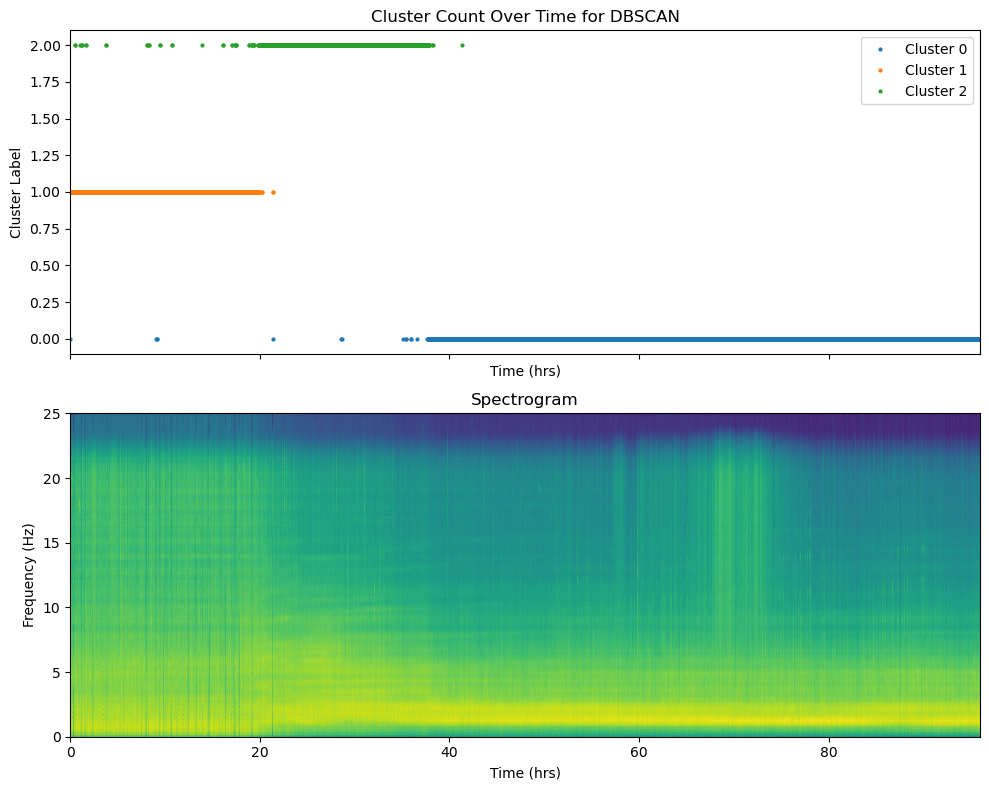

In [31]:
# show cluster count over time for DBSCAN
fig, ax = plt.subplots(2,1,figsize=(10, 8),sharex=True)
unique_labels = np.unique(labels)

for label in unique_labels:
    cluster_indices = np.where(labels == label)[0]
    cluster_timestamps = timestamps_hrs[cluster_indices]
    label_name = f"Cluster {label}" if label != -1 else "Noise"
    ax[0].plot(cluster_timestamps, np.ones_like(cluster_timestamps) * label, 'o', label=label_name, markersize=2)
ax[0].set_title("Cluster Count Over Time for {}".format(CLUSTER_TYPE))
ax[0].set_xlabel("Time (hrs)")
ax[0].set_ylabel("Cluster Label")
ax[0].legend()

ax[1].pcolormesh(timestamps_hrs, psd_freqs, psd_features.T, shading='gouraud', cmap='viridis')
ax[1].set_title("Spectrogram")
ax[1].set_xlabel("Time (hrs)")
ax[1].set_ylabel("Frequency (Hz)")
plt.tight_layout()

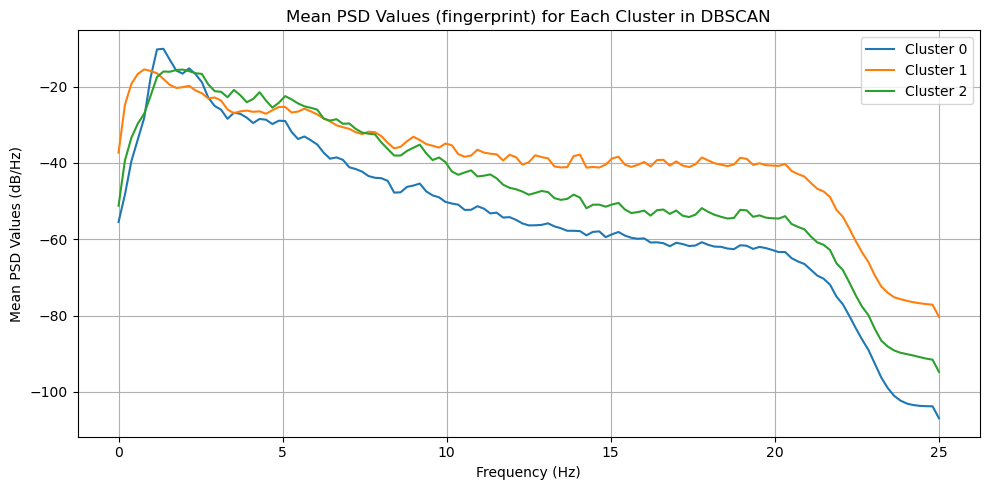

In [33]:
# calculate mean psd features for each cluster
mean_psd_features = []
for label in unique_labels:
    if label == -1:  # skip noise points
        continue
    cluster_indices = np.where(labels == label)[0]
    mean_psd_features.append(np.mean(psd_features[cluster_indices], axis=0))
mean_psd_features = np.array(mean_psd_features)
# plot the mean psd features for each cluster
fig, ax = plt.subplots(figsize=(10, 5))
for i, mean_feature in enumerate(mean_psd_features):
    ax.plot(psd_freqs,mean_feature, label=f"Cluster {i}")
ax.set_title("Mean PSD Values (fingerprint) for Each Cluster in {}".format(CLUSTER_TYPE))
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Mean PSD Values (dB/Hz)")
ax.legend()
ax.grid()
plt.tight_layout()

Text(0.5, 1.0, 'Which method\nand how many clusters?')

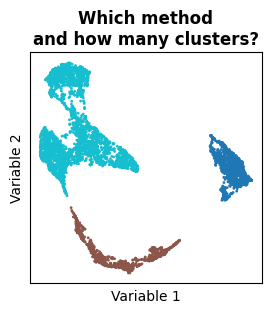

In [11]:
# scatter plot of umap with DBSCAN labels
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(umap_features[:, 0], umap_features[:, 1], c=dbscan_labels, s=1, cmap='tab10')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Variable 1')
ax.set_ylabel('Variable 2')
#ax.set_title('Cluster analysis', weight='bold')
ax.set_title('Which method\nand how many clusters?', weight='bold')

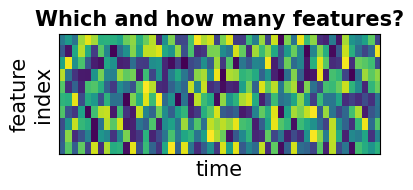

In [12]:
# show random matrix
fig, ax = plt.subplots(figsize=(4, 2))
random_matrix = np.random.rand(10, 50)
ax.imshow(random_matrix, cmap='viridis', aspect='auto')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('feature\nindex', fontsize=15)
#ax.set_title('Calculate and aggregate\nset of features', fontsize=15, weight='bold')
ax.set_title('Which and how many features?', fontsize=15, weight='bold')
plt.tight_layout()